In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as udata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import time
import copy

In [2]:
USE_GPU = torch.cuda.is_available()

In [3]:
# some utility
class TT(object):
    def __init__(self, train, test):
        self.train = train
        self.test = test
    def __getitem__(self, item):
        if item == 'train':
            return self.train
        elif item == 'test':
            return self.test
        
        raise KeyError(item)
    def __iter__(self):
        return iter(['train', 'test'])
    
def files(path): return glob.glob(path)

def timeDelta(since):
    """Calculate the time delta `now` to `since` and return it as formatted string
    """
    now = time.time()
    secs = now - since
    mins = int(secs / 60)
    secs -= mins * 60
    return '%dm %ds' % (mins, secs)

def train_model(model, loaders, criterion, optimizer, scheduler=None, num_epochs=30, eval_hook=None):
    """Train the given model over several epochs.
    
    loaders - ``TT`` containing the dataloaders for the train, test dataset
    criterion - Criterion for loss calculation
    optimizer - The optimizer to use
    scheduler - A ``torch.optim.lr_optimizer`` to schedule the learning rate or None
    num_epochs - The number of epochs to train for
    eval_hook - Callable, take current `output`, `target` and return a criterion for model fitness (less is better).
        If None, the default criterion is used.
    
    Returns best model
    """
    startTime = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_fitness = 1e9
    
    all_fitness = TT([], [])
    all_loss = TT([], [])
    
    for epoch in range(1, num_epochs + 1):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs))
        
        for phase in loaders:
            model.train(phase == 'train')
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            rloss = 0
            rfitness = 0
            
            for data in loaders[phase]:
                inputs, targets = data
                if USE_GPU:
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                inputs, targets = Variable(inputs), Variable(targets)
                
                optimizer.zero_grad()
                
                output = model(inputs)
                loss = criterion(output, targets)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                loss = loss.data[0] * inputs.size(0)
                if eval_hook is None:
                    fitness = loss
                else:
                    fitness = eval_hook(outputs, targets)
                rloss += loss
                rfitness += fitness
            
            epoch_loss = rloss / len(loaders[phase])
            epoch_fitness = rfitness / len(loaders[phase])
            
            all_fitness[phase].append(epoch_fitness)
            all_loss[phase].append(epoch_loss)
            
            print('%s (%s)\t| Loss: %.4f Fitness: %.4f' % (phase.upper(), timeDelta(startTime), epoch_loss, epoch_fitness))
            
            if phase == 'test' and epoch_fitness < best_fitness:
                best_fitness = epoch_fitness
                best_model = copy.deepcopy(model.state_dict())
    print()

    print('Finished. (%s)' % timeDelta(startTime))
    print('Best model: Fitness - %.4f' % best_fitness)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(all_fitness.train, label='train')
    ax1.plot(all_fitness.test, label='test')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Fitness')
    ax1.legend()
    ax2.plot(all_loss.train, label='train')
    ax2.plot(all_loss.test, label='test')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()
    
    
    model.load_state_dict(best_model)
    return model

In [4]:
# some data bootstrapping for demo purposes
size_training_set = 10
size_test_set = 10
train_inp = torch.randn(size_training_set, 3, 12) # arbitrary sample dimension 3, 12
train_target = torch.randn(size_training_set, 4) # arbitrary label dimension 4

test_inp = torch.randn(size_test_set, 3, 12)
test_target = torch.randn(size_test_set, 4)

In [5]:
class Net(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.layer1 = nn.Linear(3 * 12, 4)
    
    def forward(self, inp):
        out = F.tanh(self.layer1(inp.view(-1, 3 * 12)))
        return out

model = Net()

if USE_GPU:
    model = model.cuda()

In [6]:
datasets = TT(
    udata.TensorDataset(train_inp, train_target),
    udata.TensorDataset(test_inp, test_target)
)

loaders = TT(*(udata.DataLoader(datasets[i],
                                batch_size=4,
                                shuffle=True,
                                num_workers=4) for i in datasets))


In [7]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # or None

----------
Epoch 1/30
TRAIN (0m 0s)	| Loss: 4.1227 Fitness: 4.1227
TEST (0m 0s)	| Loss: 4.3236 Fitness: 4.3236
----------
Epoch 2/30
TRAIN (0m 0s)	| Loss: 0.9430 Fitness: 0.9430
TEST (0m 0s)	| Loss: 4.6496 Fitness: 4.6496
----------
Epoch 3/30
TRAIN (0m 0s)	| Loss: 0.9598 Fitness: 0.9598
TEST (0m 0s)	| Loss: 4.6632 Fitness: 4.6632
----------
Epoch 4/30
TRAIN (0m 0s)	| Loss: 0.6961 Fitness: 0.6961
TEST (0m 0s)	| Loss: 4.8002 Fitness: 4.8002
----------
Epoch 5/30
TRAIN (0m 0s)	| Loss: 0.7484 Fitness: 0.7484
TEST (0m 0s)	| Loss: 4.7640 Fitness: 4.7640
----------
Epoch 6/30
TRAIN (0m 0s)	| Loss: 0.6313 Fitness: 0.6313
TEST (0m 0s)	| Loss: 4.7513 Fitness: 4.7513
----------
Epoch 7/30
TRAIN (0m 1s)	| Loss: 0.6029 Fitness: 0.6029
TEST (0m 1s)	| Loss: 4.7622 Fitness: 4.7622
----------
Epoch 8/30
TRAIN (0m 1s)	| Loss: 0.5761 Fitness: 0.5761
TEST (0m 1s)	| Loss: 4.8531 Fitness: 4.8531
----------
Epoch 9/30
TRAIN (0m 1s)	| Loss: 0.5523 Fitness: 0.5523
TEST (0m 1s)	| Loss: 4.9465 Fitness: 4.9465
-

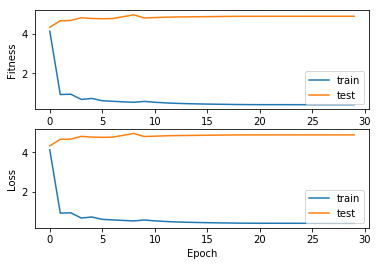

In [8]:
best_model = train_model(model, loaders, criterion, optimizer, scheduler=scheduler, num_epochs=30)